# Segmentez des clients d'un site e-commerce

- **Projet 5 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 1 : Nettoyage et analyse exploratoire des données

<img  width="76" height="30" src="https://olist.com/wp-custom/themes/olist20/assets/img/brand.svg" alt="Logo olist">


<!--TABLE OF CONTENTS-->

- [1. Compréhension du problème](#1.-Compréhension-du-problème)
  - [1.1 Mission](#1.1-Mission)
  - [1.2 Requirements : Bibliothèques utilisées dans ce notebook](#1.2-Requirements-:-Bibliothèques-utilisées-dans-ce-notebook)
  - [1.3 Des fonctions utilitaires](#1.3-Des-fonctions-utilitaires)
  - [1.4 Des routines statistiques](#1.4-Des-routines-statistiques)
- [2. Import et nettoyage des données](#2.-Import-et-nettoyage-des-données)
  - [2.1 Description des données (metadata)](<#2.1-Description-des-données-(metadata)>)
  - [2.2 Import des données](#2.2-Import-des-données)
  - [2.3 Description de données (après import)](<#2.3-Description-de-données-(après-import)>)
  - [2.4 Nettoyage des données](#2.4-Nettoyage-des-données)
- [3. Analyse Exploratoire](#3.-Analyse-Exploratoire)
  - [3.1 Données numériques](#3.1-Données-numériques)
  - [3.2 Données catégoriques](#3.2-Données-catégoriques)
  - [3.3 Associations entre variables catégoriques et numériques](#3.3-Associations-entre-variables-catégoriques-et-numériques)
- [4. Feature Engineering](#4.-Feature-Engineering)
  - [4.1 Nouvelles 'features' catégoriques](#4.1-Nouvelles-'features'-catégoriques)
  - [4.2 Nouvelles 'features' numériques](#4.2-Nouvelles-'features'-numériques)
- [5. Enregistrement des données nettoyées](#5.-Enregistrement-des-données-nettoyées)
  - [5.1 Sommaire des données nettoyées](#5.1-Sommaire-des-données-nettoyées)


# 1. Compréhension du problème

## 1.1 Mission

[Olist](https://olist.com/), une entreprise brésilienne qui propose une solution de vente sur les
marketplaces en ligne, souhaite une **segmentation des clients** que ses équipes d'e-commerce pourront
utiliser au quotidien pour leurs campagnes de communication.

- **comprendre les différents types d'utilisateurs**, grâce à leur comportement et à leurs données
  personnelles, en regroupant des clients de profils similaires. Ces catégories pourront être
  utilisées par l’équipe Marketing pour mieux communiquer.

- **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique
  sous-jacente pour une utilisation optimale

- **une proposition de contrat de maintenance**, (fréquence à laquelle la segmentation doit être
  mise à jour pour rester pertinente), basée sur une analyse de la stabilité des segments au cours
  du temps.


### Indicateurs pour segmenter les clients

#### Segmentation RFM

Pour établir des segments de clients homogènes, la [segmentation RFM](https://www.definitions-marketing.com/definition/segmentation-rfm/) prend en compte:

- la **Récence** (date de la dernière commande);
- la **Fréquence** des commandes; et
- le **Montant** (de la dernière commande ou sur une période donnée)

La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.


#### Autres indicateurs possibles

On peut aussi segmenter les clients sur d'autres indicateurs :

- leur **satisfaction** sur les commandes
- la **catégorie de produits** qu'ils commande (est-ce qu'il y a certains catégories plus satisfaisant que d'autres?)
- la **rapidité de livraison** des commandes (est-ce que les clients qui habite près des vendeurs ont un comportement diffèrent que les clients plus loin de leur commande ?)
- les **vendeurs** qu'ils adoptent (est-ce qu'il y a un rélation entre clients étoiles et certains vendeurs?)


### Objectives d'analyse exploratoire

- Connaitre les données
- Nettoyer les données
- Identifier les indicateurs actionable
- Créer des nouvelles features / indicateurs si besoin


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                      'missingno', 'dython'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import missingno as msno
import sklearn
import dython
# pour calculer VIF -Variance Influence Factor
from sklearn.linear_model import LinearRegression
# correlations catégoriques (Cramers V, Theils U)
from dython.nominal import associations


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
json==2.0.9; numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; missingno==0.5.0; sklearn==1.0.2; dython==0.6.8


### 1.2.3 Configuration défauts d'affichage


In [5]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 10)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [6]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/notebook'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [7]:
def to_png(fig_name=None) -> None:
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """

    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [8]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


# 2. Import et nettoyage des données

Olist a fournit une [base de données](https://www.kaggle.com/olistbr/brazilian-ecommerce) anonymisée
comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de
satisfaction, et la localisation des clients depuis janvier 2017.


## 2.1 Description des données (metadata)

Le data schema et déscription des champs sont fournis à la même [adresse](https://www.kaggle.com/olistbr/brazilian-ecommerce) que les données:

<img width="564" height="339" alt="Data Schema" src="https://i.imgur.com/HRhd2Y0.png">


## 2.2 Import des données


In [9]:
DATA_DIR = 'data/raw'


def load_dataset(set_name='customers'):
    filename = f'{DATA_DIR}/olist_{set_name}_dataset.csv'
    df = pd.read_csv(filename)
    print(f'{set_name}.shape = {df.shape}; columns : {list(df.columns)}')
    return df


customers = load_dataset('customers')

customers.head()


customers.shape = (99441, 5); columns : ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


## Chargé les autres datasets


In [10]:
geolocation = load_dataset('geolocation')
order_items = load_dataset('order_items')
order_payments = load_dataset('order_payments')
order_reviews = load_dataset('order_reviews')
orders = load_dataset('orders')
products = load_dataset('products')
sellers = load_dataset('sellers')
product_category_names = pd.read_csv(
    'data/raw/product_category_name_translation.csv')


geolocation.shape = (1000163, 5); columns : ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
order_items.shape = (112650, 7); columns : ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
order_payments.shape = (103886, 5); columns : ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
order_reviews.shape = (99224, 7); columns : ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
orders.shape = (99441, 8); columns : ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
products.shape = (32951, 9); columns : ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_ph

## 2.3 Description de données (après import)


In [11]:
def decrire_dataframe(df: pd.DataFrame):
    """Retourner un dataframe avec des informations sur les colonnes d'un dataframe"""
    print(f'{df.shape[0]} registres')
    ret = df.columns.to_frame(name="column").set_index('column')
    ret['% manquantes'] = df.isna().mean()
    ret['unique'] = df.nunique()
    ret['dtype'] = df.dtypes
    ret['min'] = df.min()
    ret['max'] = df.max()
    ret['std'] = df.std()
    return ret


### Customers


In [12]:
decrire_dataframe(customers)


99441 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
customer_id,0.00,99441,object,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99,nan
customer_unique_id,0.00,96096,object,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb,nan
customer_zip_code_prefix,0.00,14994,int64,1003,99990,29797.94
customer_city,0.00,4119,object,abadia dos dourados,zortea,nan
customer_state,0.00,27,object,AC,TO,nan


#### Combien de clients ont plus d'un 'customer_id'?


In [13]:
customers[['customer_id', 'customer_unique_id']].groupby(
    'customer_unique_id').agg('count').value_counts()


customer_id
1              93099
2               2745
3                203
4                 30
5                  8
6                  6
7                  3
17                 1
9                  1
dtype: int64

#### Qualité des données customer

- 100% remplis
- utilise 'customer_unique_id' pour identifier chaque client, car environ 3000 clients ont plusieurs 'customer_id'
- besoin de merge avec **geolocation** pour savoir la localisation des clients


### Geolocation


In [14]:
decrire_dataframe(geolocation)


1000163 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
geolocation_zip_code_prefix,0.00,19015,int64,1001,99990,30549.34
geolocation_lat,0.00,717358,float64,-36.61,45.07,5.72
geolocation_lng,0.00,717613,float64,-101.47,121.11,4.27
geolocation_city,0.00,8011,object,* cidade,óleo,nan
geolocation_state,0.00,27,object,AC,TO,nan


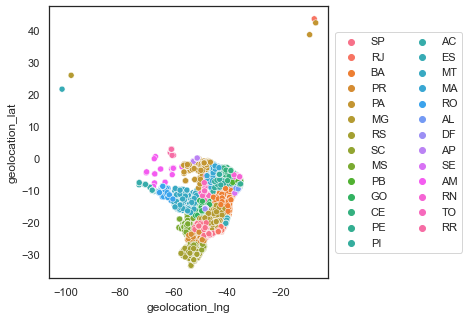

In [15]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=geolocation.sample(50000, random_state=0),
                x='geolocation_lng', y='geolocation_lat', hue='geolocation_state')
plt.legend(bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)


#### Geolocation : qualité des données

- les 'states' sont 100% remplies; il y a 27 unités fédératives au brésil
- les 'city' ne sont pas toujours des vraies villes
- les latitudes ne sont pas toujours en brésil ([5°16'20" Nord à 33°44'32" Sud de latitude](https://fr.wikipedia.org/wiki/G%C3%A9ographie_du_Br%C3%A9sil#Situation_et_%C3%A9tendue))
- les longitudes ne sont pas toujours en brésil ([34°47'30" Ouest à 73°59'32" Ouest de longitude](https://fr.wikipedia.org/wiki/G%C3%A9ographie_du_Br%C3%A9sil#Situation_et_%C3%A9tendue))
- Ce n'est pas clair pourquoi il y a environ 75 (lat,lng) pour chaque zip code - les (lat,lng) des adresses dans chaque zip ?


#### Geolocations hors brésil


In [16]:
print('trop au nord ', geolocation[geolocation['geolocation_lat'] > 5.3].shape)
print('trop au sud ',
      geolocation[geolocation['geolocation_lat'] < -33.75].shape)
print("trop à l'est",
      geolocation[geolocation['geolocation_lng'] > -34.7].shape)
print("trop à l'ouest",
      geolocation[geolocation['geolocation_lng'] < -74].shape)

mask_lat = (geolocation['geolocation_lat'] > 5.3) | (
    geolocation['geolocation_lat'] < -33.75)
mask_lng = (geolocation['geolocation_lng'] > -
            34.7) | (geolocation['geolocation_lng'] < -74)
hors_bresil = geolocation[mask_lat | mask_lng]
hors_bresil.shape


trop au nord  (26, 5)
trop au sud  (5, 5)
trop à l'est (33, 5)
trop à l'ouest (4, 5)


(42, 5)

Eliminer les outliers de (lat,lng) dans les zipcodes


Text(0.5, 1.0, 'Latitudes et longitudes de zip_code_prefix 22210 (Flamengo, Rio de Janeiro)')

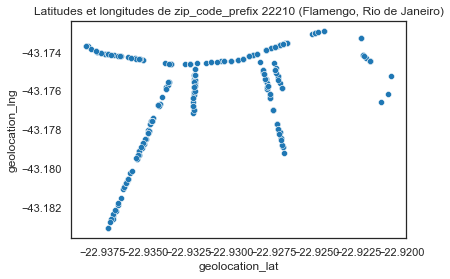

In [17]:
flamengo = geolocation[geolocation['geolocation_zip_code_prefix'] == 22210]
sns.scatterplot(data=flamengo, x='geolocation_lat',y='geolocation_lng')
plt.title('Latitudes et longitudes de zip_code_prefix 22210 (Flamengo, Rio de Janeiro)')


#### Créer geolocations uniques des zipcodes

Les données sont anonymisées, donc on prend la médiane des (lat,lng) pour chaque zip code, après avoir éliminé les 42 registres avec coordonées hors bresil (la mèdiane doit éliminer l'effet de quelques erreurs de lat,lng pour chaque zipcode)


In [18]:
geoloc: pd.DataFrame = (geolocation
                        .drop(hors_bresil.index)
                        .groupby(['geolocation_zip_code_prefix', 'geolocation_state'])
                        .agg({'geolocation_lat': 'median', 'geolocation_lng': 'median', 'geolocation_city': 'count'})
                        .rename(columns={'geolocation_city': 'count'})
                        .reset_index())
print(geoloc.shape)
decrire_dataframe(geoloc)


(19018, 5)
19018 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
geolocation_zip_code_prefix,0.00,19010,int64,1001,99990,30904.84
geolocation_state,0.00,27,object,AC,TO,nan
geolocation_lat,0.00,18993,float64,-33.69,4.48,7.24
geolocation_lng,0.00,18993,float64,-72.91,-34.80,5.20
count,0.00,483,int64,1,1146,72.06


Il y a 8 zipcodes avec duplicates :


In [19]:
geoloc_dups = geoloc[geoloc.duplicated(
    keep=False, subset=['geolocation_zip_code_prefix'])]
geoloc_dups.head(8)


,geolocation_zip_code_prefix,geolocation_state,geolocation_lat,geolocation_lng,count
367,2116,RN,-23.52,-46.58,1
368,2116,SP,-23.52,-46.58,12
1669,4011,AC,-23.58,-46.65,1
1670,4011,SP,-23.58,-46.64,178
6507,21550,AC,-22.86,-43.35,1
6508,21550,RJ,-22.86,-43.35,170
6698,23056,AC,-22.92,-43.61,1
6699,23056,RJ,-22.92,-43.61,60


Supprime les zipcodes duplicates ou il y a moins d'entrées


In [20]:
geoloc = geoloc.sort_values(by='count', ascending=False).drop_duplicates(
    keep='first', subset='geolocation_zip_code_prefix')
decrire_dataframe(geoloc)


19010 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
geolocation_zip_code_prefix,0.00,19010,int64,1001,99990,30903.69
geolocation_state,0.00,27,object,AC,TO,nan
geolocation_lat,0.00,18985,float64,-33.69,4.48,7.24
geolocation_lng,0.00,18985,float64,-72.91,-34.80,5.20
count,0.00,483,int64,1,1146,72.06


Text(0.5, 1.0, 'Localisation des zipcodes')

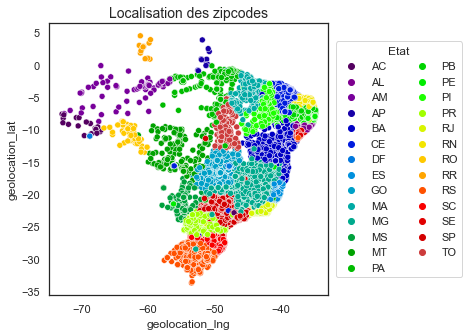

In [21]:
hue_order = sorted(geoloc['geolocation_state'].unique())
plt.figure(figsize=(5,5))
sns.scatterplot(data=geoloc, x='geolocation_lng', y='geolocation_lat',
                hue='geolocation_state', hue_order=hue_order, palette='nipy_spectral')
plt.legend(title='Etat',bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)
plt.title('Localisation des zipcodes', fontsize=14)


### Order items


In [22]:
decrire_dataframe(order_items)


112650 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
order_id,0.00,98666,object,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,nan
order_item_id,0.00,21,int64,1,21,0.71
product_id,0.00,32951,object,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58,nan
seller_id,0.00,3095,object,0015a82c2db000af6aaaf3ae2ecb0532,ffff564a4f9085cd26170f4732393726,nan
shipping_limit_date,0.00,93318,object,2016-09-19 00:15:34,2020-04-09 22:35:08,nan
price,0.00,5968,float64,0.85,6735.00,183.63
freight_value,0.00,6999,float64,0.00,409.68,15.81


In [23]:
order_items.duplicated(subset=['order_id', 'order_item_id']).sum()


0

#### Qualité des données order items

- Aucun donnée manquante
- pas de dupliquées
- prix entre 0.85 et 6735
- Données atomiques - lien entre client et vendeur


### Order payments


In [24]:
decrire_dataframe(order_payments)


103886 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
order_id,0.00,99440,object,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,nan
payment_sequential,0.00,29,int64,1,29,0.71
payment_type,0.00,5,object,boleto,voucher,nan
payment_installments,0.00,24,int64,0,24,2.69
payment_value,0.00,29077,float64,0.00,13664.08,217.49


In [25]:
len(order_payments[order_payments['payment_value'] == 0])


9

In [26]:
order_payments.groupby('order_id').agg(
    {'payment_type': set}).astype(str).value_counts()


payment_type                 
{'credit_card'}                  74259
{'boleto'}                       19784
{'voucher', 'credit_card'}        2245
{'voucher'}                       1621
{'debit_card'}                    1527
{'not_defined'}                      3
{'debit_card', 'credit_card'}        1
dtype: int64

In [27]:
order_payments.groupby('payment_type').agg(
    {'payment_value': sum}).sort_values(by='payment_value', ascending=False)


,payment_value
payment_type,
credit_card,12542084.19
boleto,2869361.27
voucher,379436.87
debit_card,217989.79
not_defined,0.00


#### Qualité des données order payments

- aucune donnée manquante
- pas clair quand le payment a été effectué
- besoin d'aggreger payment_value pour savoir si c'est égal au valeur d'achat


### Order reviews


In [28]:
decrire_dataframe(order_reviews)


99224 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
review_id,0.00,98410,object,0001239bc1de2e33cb583967c2ca4c67,fffefe7a48d22f7b32046421062219d1,nan
order_id,0.00,98673,object,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,nan
review_score,0.00,5,int64,1,5,1.35
review_comment_title,0.88,4527,object,NaN,NaN,nan
review_comment_message,0.59,36159,object,NaN,NaN,nan
review_creation_date,0.00,636,object,2016-10-02 00:00:00,2018-08-31 00:00:00,nan
review_answer_timestamp,0.00,98248,object,2016-10-07 18:32:28,2018-10-29 12:27:35,nan


In [29]:
order_reviews.groupby('order_id').agg(
    {'review_id': 'count'}).astype(str).value_counts()


review_id
1            98126
2              543
3                4
dtype: int64

Text(0.5, 1.0, 'Distribution du score des revues')

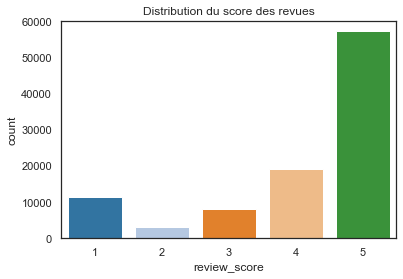

In [30]:
sns.countplot(data=order_reviews, x='review_score')
plt.title('Distribution du score des revues')


#### Qualité des données de 'review score':

- 98673 unique order_id (comparé avec 98666 unique order_id dans order_items)
- aucune données manquantes dans colonne score
- jusqu'à 3 revues par commande, mais moins de 0.5% des commandes ont plus d'un revue
- environ 40% des commandes contient un revue, seulement 10% contient un titre

Dans le perimetre de ce projet (segmentation des clients), on retient seulement le score pour chaque commande


### Orders (commandes)


In [31]:
decrire_dataframe(orders)


99441 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
order_id,0.00,99441,object,nan,nan,nan
customer_id,0.00,99441,object,nan,nan,nan
order_status,0.00,8,object,nan,nan,nan
order_purchase_timestamp,0.00,98875,object,nan,nan,nan
order_approved_at,0.00,90733,object,nan,nan,nan
order_delivered_carrier_date,0.02,81018,object,nan,nan,nan
order_delivered_customer_date,0.03,95664,object,nan,nan,nan
order_estimated_delivery_date,0.00,459,object,nan,nan,nan


In [32]:
orders['order_status'].value_counts()


delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [33]:
orders[orders['order_status'] != 'delivered'].head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


In [34]:
decrire_dataframe(orders[orders['order_status'] == 'delivered'])


96478 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
order_id,0.00,96478,object,nan,nan,nan
customer_id,0.00,96478,object,nan,nan,nan
order_status,0.00,1,object,nan,nan,nan
order_purchase_timestamp,0.00,95956,object,nan,nan,nan
order_approved_at,0.00,88274,object,nan,nan,nan
order_delivered_carrier_date,0.00,80106,object,nan,nan,nan
order_delivered_customer_date,0.00,95658,object,nan,nan,nan
order_estimated_delivery_date,0.00,445,object,nan,nan,nan


#### Qualité de données des commandes

- autant de clients uniques que commandes
- aucune données manquantes pour les commandes livrés
- pour les commandes pas livrés, les données manquantes sont expliqués par le non-livraison

- les produits non-livrés seront plus complexe à analyser.


### Products (et product category names)


In [35]:
decrire_dataframe(products)


32951 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
product_id,0.00,32951,object,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58,nan
product_category_name,0.02,73,object,NaN,NaN,nan
product_name_lenght,0.02,66,float64,5.00,76.00,10.25
product_description_lenght,0.02,2960,float64,4.00,3992.00,635.12
product_photos_qty,0.02,19,float64,1.00,20.00,1.74
product_weight_g,0.00,2204,float64,0.00,40425.00,4282.04
product_length_cm,0.00,99,float64,7.00,105.00,16.91
product_height_cm,0.00,102,float64,2.00,105.00,13.64
product_width_cm,0.00,95,float64,6.00,118.00,12.08


In [36]:
products[products['product_category_name'].isna()].head()


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,nan,nan,nan,650.00,17.00,14.00,12.00
128,d8dee61c2034d6d075997acef1870e9b,NaN,nan,nan,nan,300.00,16.00,7.00,20.00
145,56139431d72cd51f19eb9f7dae4d1617,NaN,nan,nan,nan,200.00,20.00,20.00,20.00
154,46b48281eb6d663ced748f324108c733,NaN,nan,nan,nan,18500.00,41.00,30.00,41.00
197,5fb61f482620cb672f5e586bb132eae9,NaN,nan,nan,nan,300.00,35.00,7.00,12.00


In [37]:
products['product_category_name'].value_counts(
    normalize=True).cumsum().head()*100


cama_mesa_banho          9.37
esporte_lazer           18.23
moveis_decoracao        26.45
beleza_saude            34.00
utilidades_domesticas   41.22
Name: product_category_name, dtype: float64

In [38]:
products['product_category_name'].value_counts(normalize=True).tail()*100


fashion_roupa_infanto_juvenil   0.02
casa_conforto_2                 0.02
pc_gamer                        0.01
seguros_e_servicos              0.01
cds_dvds_musicais               0.00
Name: product_category_name, dtype: float64

#### Qualité des données 'products'

- 2% des produits n'ont pas de catégorie ni description
- 73 catégories differents, 5 catégories contient 40% des produits
- peut-être vaut le coup de cluster les catégories des produits?


### Sellers



In [39]:
decrire_dataframe(sellers)

3095 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
seller_id,0.00,3095,object,0015a82c2db000af6aaaf3ae2ecb0532,ffff564a4f9085cd26170f4732393726,nan
seller_zip_code_prefix,0.00,2246,int64,1001,99730,32713.45
seller_city,0.00,611,object,04482255,xaxim,nan
seller_state,0.00,23,object,AC,SP,nan


#### Qualité de données 'sellers'
- aucune données manquantes
- la ville n'est pas toujours une vraie ville
- environ un vendeur pour chaque 25 commandes
- besoin de merge avec geolocation pour savoir la localisation du vendeur

## 2.4 Nettoyage des données

### Geolocation des clients

Text(0.5, 1.0, 'Localisation des clients')

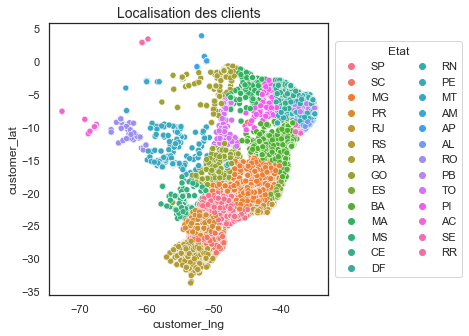

In [40]:
geolocal=geoloc[['geolocation_zip_code_prefix','geolocation_lng','geolocation_lat']]
geolocal.columns=['customer_zip_code_prefix','customer_lng','customer_lat']
customers_geo = customers.merge(geolocal, on='customer_zip_code_prefix', how='left')
plt.figure(figsize=(5,5))
sns.scatterplot(data=customers_geo,x='customer_lng', y='customer_lat', hue='customer_state')
plt.legend(title='Etat', bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)
plt.title('Localisation des clients', fontsize=14)

### Geolocation des vendeurs

Text(0.5, 1.0, 'Localisation des vendeurs')

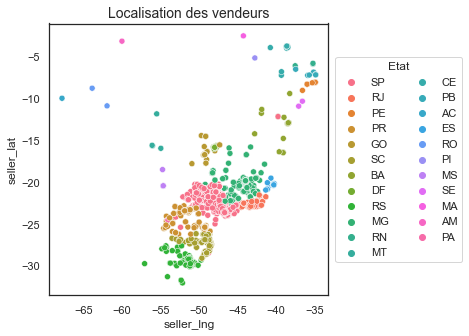

In [41]:
geolocal.columns=['seller_zip_code_prefix','seller_lng','seller_lat']
sellers_geo = sellers.merge(geolocal, on='seller_zip_code_prefix', how='left')
plt.figure(figsize=(5,5))
sns.scatterplot(data=sellers_geo,x='seller_lng', y='seller_lat', hue='seller_state')
plt.legend(title='Etat', bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)
plt.title('Localisation des vendeurs', fontsize=14)

### Catégories des produits en anglais

In [42]:
products_en=products.merge(product_category_names,on='product_category_name', how='left')
products_en.isna().sum().sort_values(ascending=False)

product_category_name_english    623
product_photos_qty               610
product_description_lenght       610
product_name_lenght              610
product_category_name            610
product_width_cm                   2
product_height_cm                  2
product_length_cm                  2
product_weight_g                   2
product_id                         0
dtype: int64

### Fusionne des tables

On essaie de fusionner (merge) les données de plusieurs tables, pour ensuite pouvoir génerer les indicateurs nécessaire pour segmentation.

On fait la merge finale sur order_items

# 3. Analyse Exploratoire


## 3.1 Données numériques


## 3.2 Données catégoriques


## 3.3 Associations entre variables catégoriques et numériques


# 4. Feature Engineering


## 4.1 Nouvelles 'features' catégoriques


## 4.2 Nouvelles 'features' numériques


## 4.3 Pipeline de Feature Engineering


# 5. Enregistrement des données nettoyées


## 5.1 Sommaire des données nettoyées
